In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve



In [10]:
speeds = np.array([0.1,0.2,0.4,0.5,0.6,0.7,0.81,0.9,1.0])

In [11]:

def bar(t, xc, b = 0.160, v = 1):

    if xc >=-b+v*t and xc <=b+v*t :
        return 1
    else: 
        return 0
    

In [42]:
data = {}
cell = 150

nets_list = ['Reciporcal_mono_linear/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_mono_linear/noGCGainControl/betaA/betaA_0.0',
             'Reciporcal_mono_linear/noGCGainControl/betaA/betaA_0.1',
             'Reciporcal_mono_linear/noGCGainControl/betaB/betaB_0.0']

for net in nets_list:
    
    data[net] = {}

    bars = []
    tps_rf_GC_mid = []
    times = []

    Fs = []
    RBs = []
    RGs = []
    OBs = []
    OAs = []

    peaks_RG = []
    peaks_RB = []
    peaks_drive = []

    ants_RB_drive = []
    ants_RB_bar = []

    ants_RG_drive = []
    ants_RG_bar = []

    omins_B = []
    omins_A = []

    for s in speeds: 
        fp = f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net}/smooth_{s}'
        with open(f'{fp}/out', 'rb') as handle:
            out = pickle.load(handle)    
            
        with open(f'{fp}/params', 'rb') as handle:
            paramsi = pickle.load(handle)
            
        duration = paramsi['duration']
        dt = paramsi['dt']
        time = np.arange(0,duration,dt) #- (paramsi['spacing']*cell)/paramsi['speed']#*1000#+45
        pos_cell = paramsi['pos_rf_GC_mid'][cell]
        barr = [bar(t,pos_cell, v = s) for t in time]
        tp_bar = paramsi['tps_rf_GC_mid'][cell]

        peak_RB = time[np.argmax(out['RB'][50,:])]
        peak_RG = time[np.argmax(out['RG'][:])]
        peak_drive = time[np.argmax(out['F'][:])]

        omin_B = np.min(out['OB'][50,:])
        omin_A = np.min(out['OA'][50,:])


        # RAM
        ant_RB_drive =  peak_drive - peak_RB
        ant_RB_bar  =  tp_bar - peak_RB

        ant_RG_drive =  peak_drive - peak_RG
        ant_RG_bar =  tp_bar - peak_RG

        bars.append(barr)
        tps_rf_GC_mid.append(tp_bar)
        times.append(time)

        Fs.append(out['F'])
        RBs.append(out['RB'][50,:])
        RGs.append(out['RG'])
        OBs.append(out['OB'][50,:])
        OAs.append(out['OA'][50,:])

        peaks_RB.append(peak_RB)
        peaks_RG.append(peak_RG)
        peaks_drive.append(peak_drive)

        ants_RB_drive.append(ant_RB_drive)
        ants_RB_bar.append(ant_RB_bar)
        
        ants_RG_drive.append(ant_RG_drive)
        ants_RG_bar.append(ant_RG_bar)

        omins_B.append(omin_B)
        omins_A.append(omin_A)


    data[net]['peaks']={}
    data[net]['peaks']['RB'] = np.asarray(peaks_RB)
    data[net]['peaks']['RG'] = np.asarray(peaks_RG)
    data[net]['peaks']['drive'] =np.asarray( peaks_drive)

    data[net]['omin'] = {}
    data[net]['omin']['B'] = np.asarray(omins_B)
    data[net]['omin']['A'] = np.asarray(omins_A)

    data[net]['ants'] ={}
    data[net]['ants']['RB_drive'] =np.asarray(ants_RB_drive)
    data[net]['ants']['RB_bar'] =np.asarray(ants_RB_bar)
    data[net]['ants']['RG_drive'] =np.asarray(ants_RG_drive)
    data[net]['ants']['RG_bar'] =np.asarray(ants_RG_bar)
    
    data[net]['RB'] = RBs
    data[net]['RG'] = RGs
    data[net]['F'] = Fs
    data[net]['OB'] = OBs
    data[net]['OA'] = OAs

    data['bars'] = bars
    data['tps_rf_mid'] = np.asarray(tps_rf_GC_mid)
    data['times'] = times

# tp of bar at cell's rf center

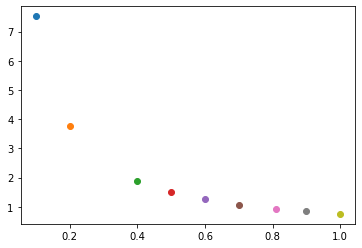

In [43]:
for i,s in enumerate(speeds):
    plt.scatter(s,data['tps_rf_mid'][i])

# scaling anticipation to bar  all versions

# 

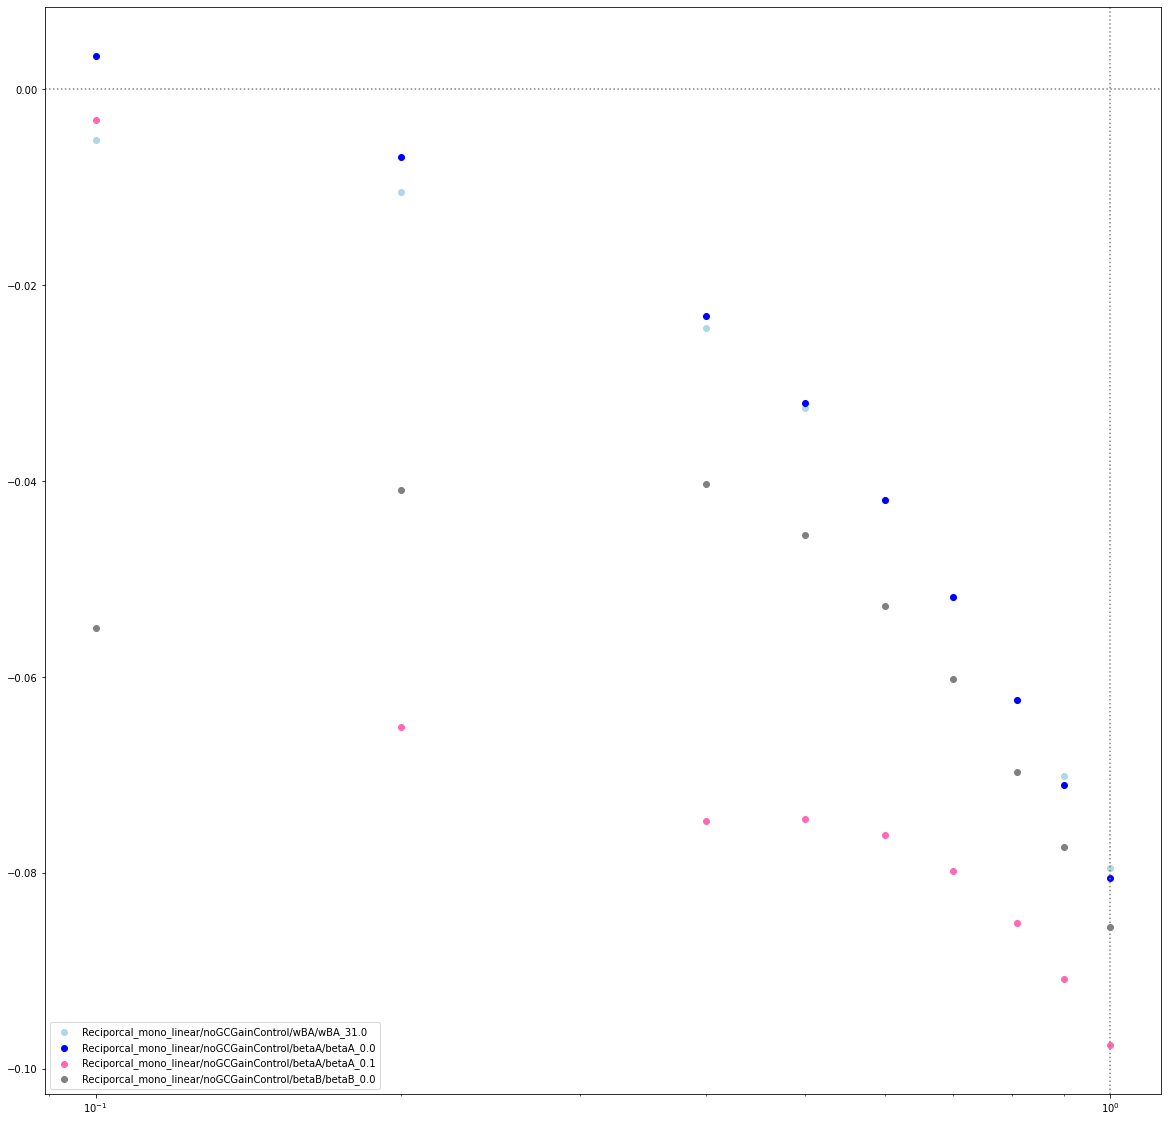

In [44]:
colors = ['lightblue', 'blue','hotpink', 'grey', 'lightgrey']

plt.figure(figsize =(20,20))
for i,net in enumerate(nets_list):
    # print(data[net]['ants']['RB_drive'])
    antis = np.array(data[net]['ants']['RG_bar'])*speeds 
    plt.scatter(speeds,antis, color = colors[i],label = net)

plt.axhline(0, color = 'grey', linestyle = ':')
plt.axvline(1, color = 'grey', linestyle = ':')
plt.xscale('log')
plt.legend()

## compare biphasic RAM effect plasticity B

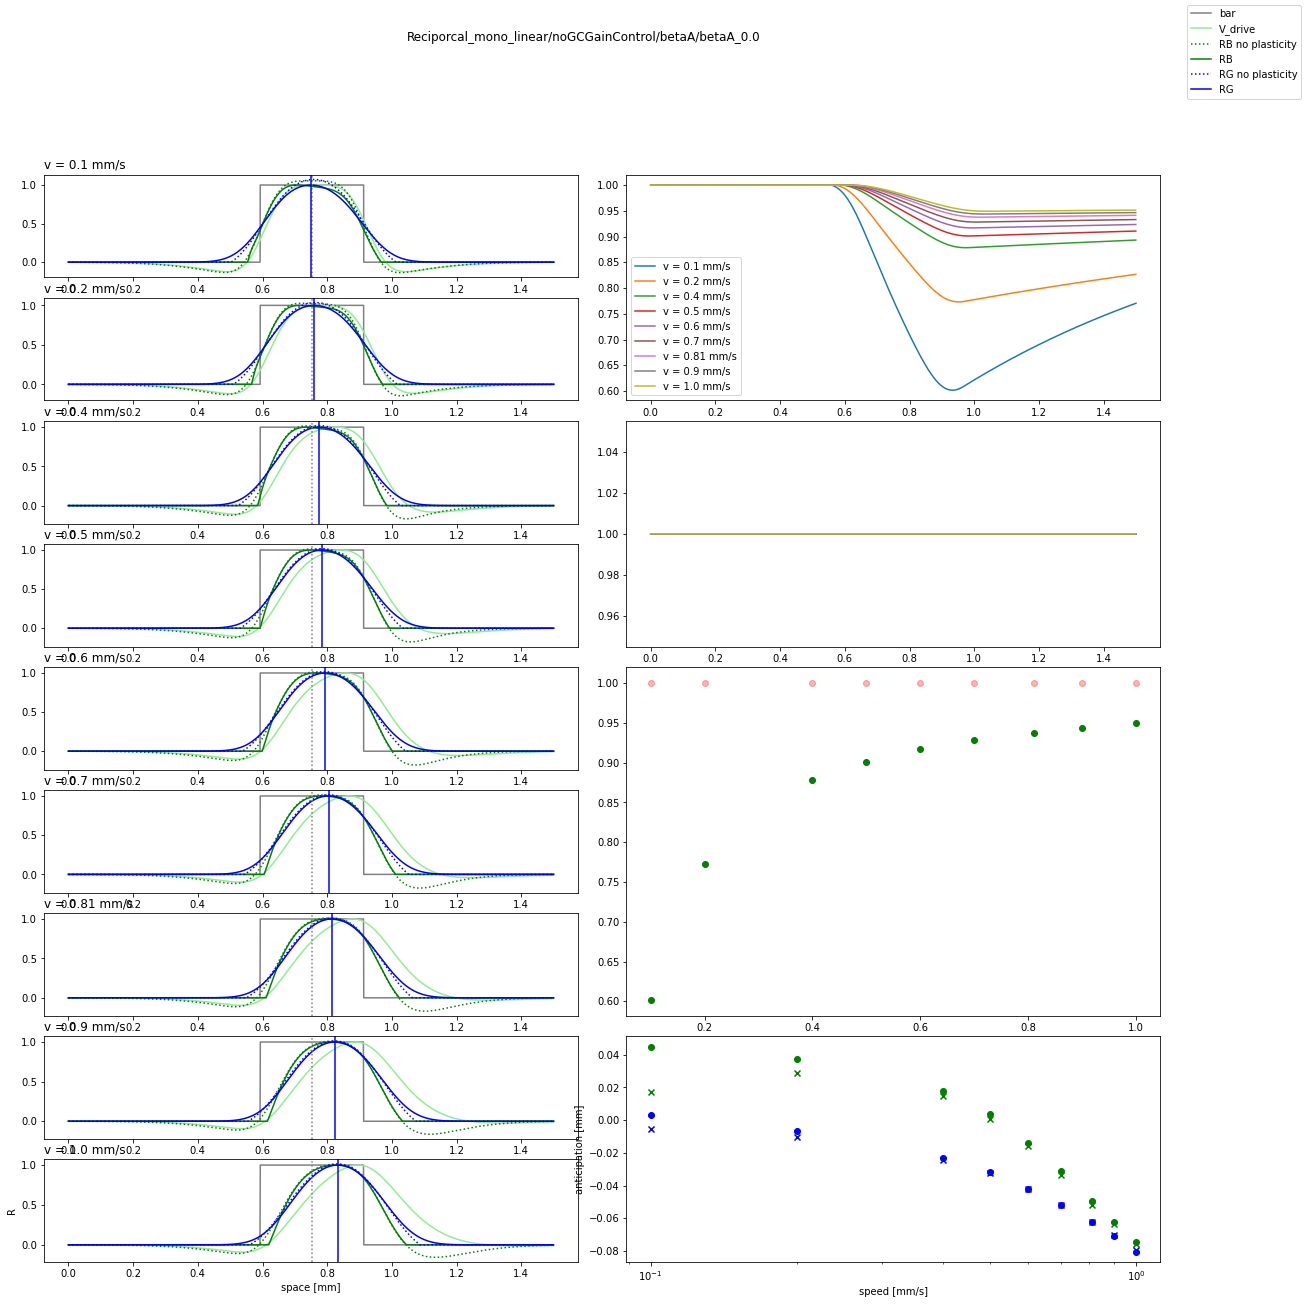

In [45]:
fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds),4)

net = nets_list[1]
net_nop = nets_list[0]
otB = fig.add_subplot(gs[:2,2:])
otA = fig.add_subplot(gs[2:4,2:])
tst = []
for i,s in enumerate(speeds):
    
    #title
    if i == 0:
        ax = fig.add_subplot(gs[i,:2])
    else:
        ax = fig.add_subplot(gs[i,:2], sharex = ax)
        
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net]['F'][i]/np.max(data[net]['F'][i]), label = f'V_drive', color = 'lightgreen')

    # plot RB
    ax.plot(data['times'][i]*s,data[net_nop]['RB'][i]/np.max(data[net]['RB'][i]), label = f'RB no plasticity', color = 'green', linestyle = ':')
    ax.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][i]), label = f'RB', color = 'green')

    # plot RG
    ax.plot(data['times'][i]*s,data[net_nop]['RG'][i]/np.max(data[net]['RG'][i]), label = f'RG no plasticity', color = 'blue', linestyle = ':')
    ax.plot(data['times'][i]*s,data[net]['RG'][i]/np.max(data[net]['RG'][i]), label = f'RG', color = 'blue')

    ax.axvline(data['tps_rf_mid'][i]*s, color = 'grey', linestyle = ':')
    ax.axvline(data[net]['peaks']['RG'][i]*s, color = 'blue')
    if i ==0 :
        fig.legend()


    otB.plot(data['times'][i]*s, data[net]['OB'][i], label = f'v = {s} mm/s')
    otA.plot(data['times'][i]*s, data[net]['OA'][i], label = f'v = {s} mm/s')

    #ot.scatter(speeds, data[net]['omin']['A']*speeds, color = 'red')
otB.legend()
ax.set_xlabel('space [mm]')
ax.set_ylabel('R')



fig.suptitle(f'{net}')

an = fig.add_subplot(gs[7:,2:])  
an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'green')
an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'blue')
an.scatter(speeds, data[net_nop]['ants']['RB_bar']*speeds,marker= 'x', color = 'green')
an.scatter(speeds, data[net_nop]['ants']['RG_bar']*speeds,marker= 'x',  color = 'blue')
an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')


o = fig.add_subplot(gs[4:7,2:])
o.scatter(speeds, data[net]['omin']['B'], color = 'green')
o.scatter(speeds, data[net]['omin']['A'], color = 'red', alpha = 0.3)


# plasticity both

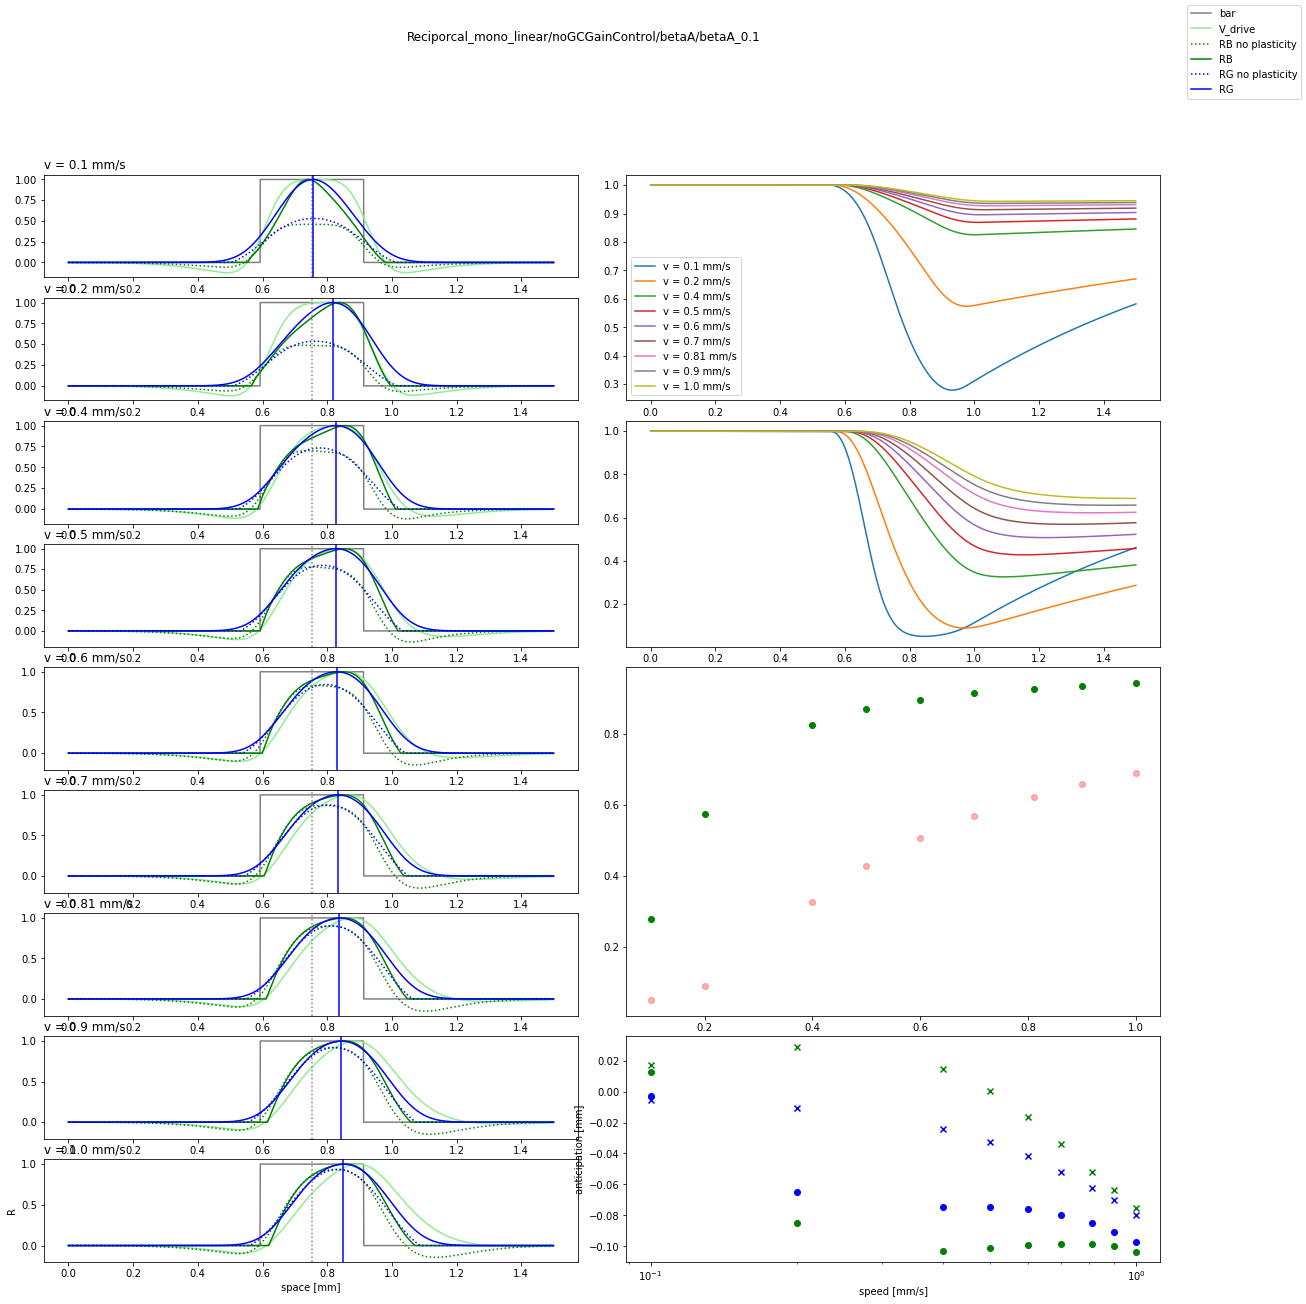

In [46]:
fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds),4)

net = nets_list[2]
net_nop = nets_list[0]
otB = fig.add_subplot(gs[:2,2:])
otA = fig.add_subplot(gs[2:4,2:])
tst = []
for i,s in enumerate(speeds):
    
    #title
    if i == 0:
        ax = fig.add_subplot(gs[i,:2])
    else:
        ax = fig.add_subplot(gs[i,:2], sharex = ax)
        
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net]['F'][i]/np.max(data[net]['F'][i]), label = f'V_drive', color = 'lightgreen')

    # plot RB
    ax.plot(data['times'][i]*s,data[net_nop]['RB'][i]/np.max(data[net]['RB'][i]), label = f'RB no plasticity', color = 'green', linestyle = ':')
    ax.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][i]), label = f'RB', color = 'green')

    # plot RG
    ax.plot(data['times'][i]*s,data[net_nop]['RG'][i]/np.max(data[net]['RG'][i]), label = f'RG no plasticity', color = 'blue', linestyle = ':')
    ax.plot(data['times'][i]*s,data[net]['RG'][i]/np.max(data[net]['RG'][i]), label = f'RG', color = 'blue')

    ax.axvline(data['tps_rf_mid'][i]*s, color = 'grey', linestyle = ':')
    ax.axvline(data[net]['peaks']['RG'][i]*s, color = 'blue')
    if i ==0 :
        fig.legend()


    otB.plot(data['times'][i]*s, data[net]['OB'][i], label = f'v = {s} mm/s')
    otA.plot(data['times'][i]*s, data[net]['OA'][i], label = f'v = {s} mm/s')

    #ot.scatter(speeds, data[net]['omin']['A']*speeds, color = 'red')
otB.legend()
ax.set_xlabel('space [mm]')
ax.set_ylabel('R')



fig.suptitle(f'{net}')

an = fig.add_subplot(gs[7:,2:])  
an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'green')
an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'blue')
an.scatter(speeds, data[net_nop]['ants']['RB_bar']*speeds,marker= 'x', color = 'green')
an.scatter(speeds, data[net_nop]['ants']['RG_bar']*speeds,marker= 'x',  color = 'blue')
an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')


o = fig.add_subplot(gs[4:7,2:])
o.scatter(speeds, data[net]['omin']['B'], color = 'green')
o.scatter(speeds, data[net]['omin']['A'], color = 'red', alpha = 0.3)


# plasticity A

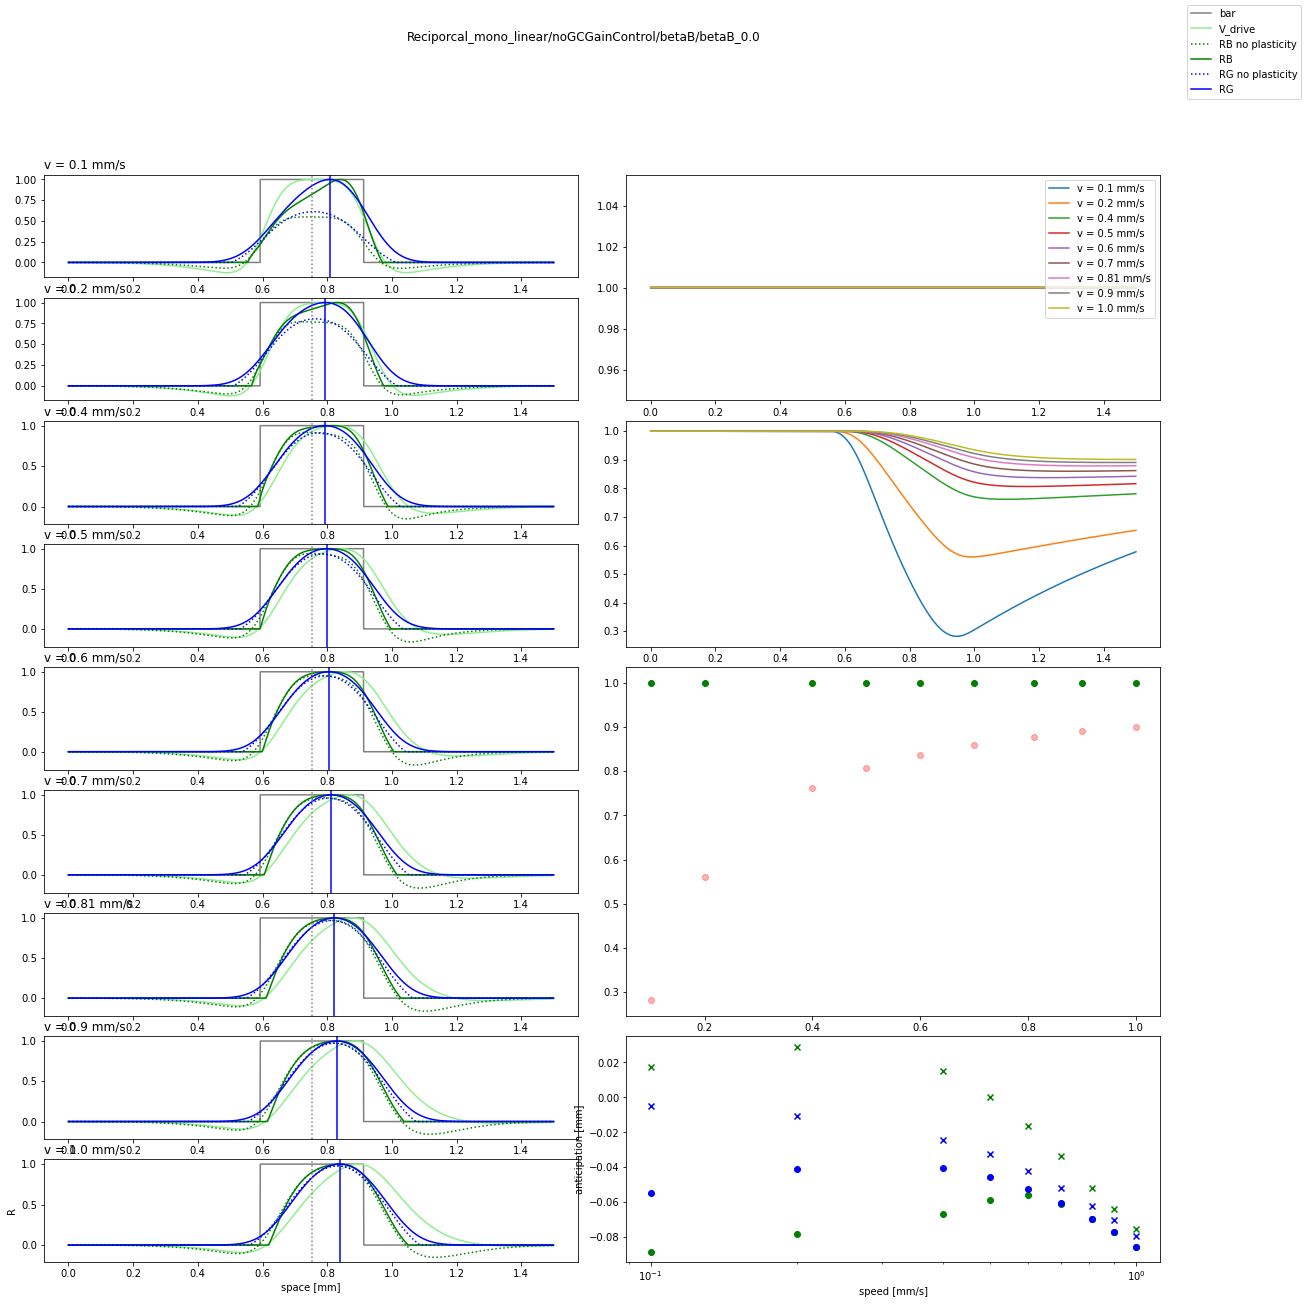

In [47]:
fig = plt.figure(figsize = (20,20))
gs = fig.add_gridspec(len(speeds),4)

net = nets_list[3]
net_nop = nets_list[0]
otB = fig.add_subplot(gs[:2,2:])
otA = fig.add_subplot(gs[2:4,2:])
tst = []
for i,s in enumerate(speeds):
    
    #title
    if i == 0:
        ax = fig.add_subplot(gs[i,:2])
    else:
        ax = fig.add_subplot(gs[i,:2], sharex = ax)
        
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    ax.plot(data['times'][i]*s,data['bars'][i], label = f'bar', color = 'grey')

    # plot drive 
    ax.plot(data['times'][i]*s,data[net]['F'][i]/np.max(data[net]['F'][i]), label = f'V_drive', color = 'lightgreen')

    # plot RB
    ax.plot(data['times'][i]*s,data[net_nop]['RB'][i]/np.max(data[net]['RB'][i]), label = f'RB no plasticity', color = 'green', linestyle = ':')
    ax.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][i]), label = f'RB', color = 'green')

    # plot RG
    ax.plot(data['times'][i]*s,data[net_nop]['RG'][i]/np.max(data[net]['RG'][i]), label = f'RG no plasticity', color = 'blue', linestyle = ':')
    ax.plot(data['times'][i]*s,data[net]['RG'][i]/np.max(data[net]['RG'][i]), label = f'RG', color = 'blue')

    ax.axvline(data['tps_rf_mid'][i]*s, color = 'grey', linestyle = ':')
    ax.axvline(data[net]['peaks']['RG'][i]*s, color = 'blue')
    if i ==0 :
        fig.legend()


    otB.plot(data['times'][i]*s, data[net]['OB'][i], label = f'v = {s} mm/s')
    otA.plot(data['times'][i]*s, data[net]['OA'][i], label = f'v = {s} mm/s')

    #ot.scatter(speeds, data[net]['omin']['A']*speeds, color = 'red')
otB.legend()
ax.set_xlabel('space [mm]')
ax.set_ylabel('R')



fig.suptitle(f'{net}')

an = fig.add_subplot(gs[7:,2:])  
an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'green')
an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'blue')
an.scatter(speeds, data[net_nop]['ants']['RB_bar']*speeds,marker= 'x', color = 'green')
an.scatter(speeds, data[net_nop]['ants']['RG_bar']*speeds,marker= 'x',  color = 'blue')
an.set_xscale('log')
an.set_xlabel('speed [mm/s]')
an.set_ylabel('anticipation [mm]')


o = fig.add_subplot(gs[4:7,2:])
o.scatter(speeds, data[net]['omin']['B'], color = 'green')
o.scatter(speeds, data[net]['omin']['A'], color = 'red', alpha = 0.3)
